## Word2vec
A difficulty of working with text data is that using each word of a large vocabulary as a feature requires working with large dimensions. While sparse matrix data structures make manipulating these vectors tractable, there are whole classes of algorithms that do not work well or at all on sparse high dimensional data. 

A somewhat recent development called word2vec allows words to be represented as dense vectors of much smaller dimensions (on the order of $\mathbb{R}^{100}$). This algorithm yields representations of words such that words appearing in similar contexts will lie close to one another in this low dimensional vector space. Another interesting feature of this algorithm is that the representation does a good job at inferring analogies. [This gensim demo](http://rare-technologies.com/word2vec-tutorial/#app) of the algorithm shows word2vec inferring that *dogs* is to *puppies* as *cats* is to *kittens*:

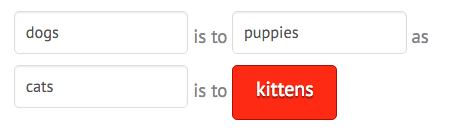

In [1]:
from IPython.display import Image
Image(filename='kittens.png')


At a high level, the skip-gram flavor of this algorithm looks at a word and its surrounding  words, and tries to maximize the probability that the word's vector representation predicts those actual words occurring around it. If it is trained on the phrase *the quick brown fox jumps*, the word2vec input representation of the word *brown* would yield a high dot product with the output vectors for the words *the, quick, fox* and *jumps*. And if the algorithm is trained on a lot more text, there's a good chance that it will start to learn that the words $brown$ and $red$ appear in similar contexts, so that their vector representations will be pretty close to one another's.

## Speed
I'm constantly trying to navigate the trade-off from simultaneously maximizing my laziness and the speed of my code. Aiming for the lazy side, I originally wanted to experiment with using [autograd](https://github.com/HIPS/autograd) to write my gradient updates for me, and as nice as it was to not have to write out the gradient calculation, this pretty quickly bubbled to the top as one of the major bottlenecks, leaving me to write the gradients manually by faster means.

While numpy gives a big speed boost over plain python, cython (used by the go-to word2vec implementation, [gensim](https://github.com/piskvorky/gensim)), gives a major performance improvement beyond numpy, with speeds often comparable to code written in C. Part of the cost of this speed up is that writing in Cython, while more pythonic than C, seems to require additional type annotations and syntactic elements, making it less readable and less interesting to write (at least for me). My goal here has been to make word2vec as close to gensim's cython performance as possible while sticking to Python, so I settled on Numba, a numeric JIT compiler that uses LLVM and supports a subset of Python and numpy.

While I ran into some limitations of numba, rewriting the inner loops in Numba functions ended up giving a significant speed-boost. I did a lot of profiling and iterating to find the major bottlenecks of the gradient descent learning, and while I don't know of a good way to communicate the iterative stone-smoothing process that is program optimization,  I've left the original numpy and improved numba versions of some of these functions for microbenchmark comparison.

# Let's get started
[#Benchmarks](#Benchmarks)

In [2]:
%%javascript
var csc = IPython.keyboard_manager.command_shortcuts
csc.add_shortcut('Ctrl-k','ipython.move-selected-cell-up')
csc.add_shortcut('Ctrl-j','ipython.move-selected-cell-down')
csc.add_shortcut('Shift-m','ipython.merge-selected-cell-with-cell-after')

<IPython.core.display.Javascript object>

In [3]:
from project_imports import *
%matplotlib inline

In [4]:
import wordvec_utils as wut; reload(wut);
from wordvec_utils import Cat, WordVectorizer, update, Conf
import utils as ut; reload(ut);
from utils import take, ilen

from numba_utils import ns_grad as ns_grad_jit, nseed
import numba_utils as nbu; reload(nbu)
from autograd import numpy as npa, grad

from numba import jit, njit
from numpy import array
from numpy.linalg import norm

[#Evaluate](#Evaluate)

## Objective functions

The standard skip-gram objective function comes from taking the softmax probability of each of the actual context word vectors dotted with the input ($u_{c,j^*_c}$) and multiplying them together:

\begin{align}
E & = -\log \prod_{c=1} ^{C}
    \frac {\exp (u_{c,j^*_c})}
          {\sum_{j'=1} ^ V \exp(u_{j'})} \\
  & = -\sum^C_{c=1} u_{j^*_c} + C \cdot \log \sum ^ V _{j'=1} \exp(u_j')
\end{align}

See [word2vec Parameter Learning Explained](http://www-personal.umich.edu/~ronxin/pdf/w2vexp.pdf) for a detailed explanation, and note that the algorithm keeps 2 representations for each word, an input vector from $W$, and an output vector from $W'$ (`W1` and `W2` in the code).
Though I ended up using a different objective called negative sampling, I kept this original objective below as `skipgram_likelihood`, written as a nested function since autograd requires single-argument functions to differentiate:

In [5]:
def skipgram_likelihood(wi, cwds, dv=None):
    wix = dv.get(wi)
    cixs = dv.get(cwds)
    C = len(cwds)

    def logloss(Wall):
        W1, W2 = Cat.split(Wall)
        h = W1[wix, :]  # ∈ ℝⁿ
        u = np.dot(h, W2)
        ucs = u[cixs]
        return -np.sum(ucs) + C * np.log(np.sum(np.exp(u)))
    return logloss

The return value of `logloss` should pretty clearly resemble the equation above.

# Negative sampling
## Gradient

After reading a bit more about word2vec, I found out about an extension to the skip-gram model called negative sampling that efficiently generates better word vectors. The basic idea is that in addition to training a word vector with $C$ words that *do* appear around it, the vector should also be trained with $K$ words randomly chosen from the rest of the text, as negative examples of what the vector should *not* predict in its context. 

As a side-note to keep up with the notation taken from [word2vec Parameter Learning Explained](http://www-personal.umich.edu/~ronxin/pdf/w2vexp.pdf), the term $\boldsymbol v_{w_O}'$ refers to a word vector ($\boldsymbol v$) that is from the output vector matrix ($\boldsymbol v'$) representing an output word $w_O$. Notation aside, the gradient for the negative sampling extension is relatively straightforward. For each true context word vector $\boldsymbol v_{w_O}'$ appearing close to the input word vector $h$, we'll draw $K$ word vectors $\boldsymbol v_{w_i}$ at random from the corpus. The objective is computed by adding the log of the sigmoid of the word vector dotted with either the true or false context word (the negative samples are negated): 


$$
E = -\log \sigma(\boldsymbol v_{w_O}^{\prime T} \boldsymbol h)
    - \sum^K _{i=1} \log \sigma (-\boldsymbol v_{w_i} ^{\prime T} \boldsymbol h)
$$

The gradient with respect to $\boldsymbol v_{w_j}^{\prime T} \boldsymbol h$ is then as follows, where $t_j$ is an indicator for whether $w_j$ actually appears in the context:

$$
    \frac{\partial E}
         {\partial \boldsymbol v_{w_j}^{\prime T} \boldsymbol h}
         = \sigma(\boldsymbol v_{w_j}^{\prime T} \boldsymbol h) -t_j.
$$

The numpy gradient is written below as `ns_grad`; the numba gradient `ns_grad_jit` is similar, but all of the functions used in a JIT'd function must also be numba-JIT'd, so I moved them all out to the `numba_utils` module. 

The schema I adopted to calculate gradients takes a subset of the matrix formed by concatenating the input and output parameter matrices together ($W || W'$). If the vector dimension $N$ is 100, and there are 1000 words in the vocabulary, this matrix will be in $\mathbb{R}^{1000 \times 200}$. The gradient function takes a subset of this matrix with $K + 2$ rows. The first row represents the input word, the next represents the true context word, and the rest represent the $K$ negative samples.

Note that since the first vector is from the input parameter matrix $W$, and these functions are operating on the input and output matrices concatenated, we only care about the first $N$ entries of the first row. Similarly, we only care about the last $N$ entries for the rest of the output vectors. This schema should be more clear from the `get_vecs1` function below that extracts the vectors from the relevant subset of the concatenated parameter matrices. This also means that for the gradients of the concatenated matrix, half of the entries in each row will be zero.

In [6]:
getNall = lambda W: W.shape[1] // 2
gen_labels = lambda negsamps: [1] + [0] * len(negsamps)
sig = lambda x: 1 / (1 + np.exp(-x))


def get_vecs1(Wsub):
    N = getNall(Wsub)
    h = Wsub[0, :N]  # ∈ ℝⁿ
    vwo = Wsub[1, N:]
    negsamps = Wsub[2:, N:]
    return h, vwo, negsamps

def ns_loss_grads(h: 'v[n]', vout: '[v[n]]', label: 'v[n]'):
    dot = sig(vout @ h) - label
    return dot * vout, dot * h

def ns_grad(Wsub):
    h, vwo, negsamps = get_vecs1(Wsub)
    N = getNall(Wsub)
    Wsub_grad = np.zeros(Wsub.shape)

    for i, vout, label in izip(count(1), it.chain([vwo], negsamps), gen_labels(negsamps)):
        hgrad, vgrad = ns_loss_grads(h, vout, label)
        Wsub_grad[0, :N] += hgrad
        Wsub_grad[i, N:] += vgrad
    return Wsub_grad

## Gradient check
The following gradient checking functionality based on [the UFLDL tutorial](http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/) uses simple calculus to ensure that the gradients are working as expected.

In [7]:
def ns_loss(h, vwo, vwi_negs):
    """This should be called on the subset of the matrix (Win || Wout')
    determined by row indices `wi, win_ix, negwds`.
    """
    negsum = 0
    for j in xrange(len(vwi_negs)):
        negsum += np.log(sig(-vwi_negs[j] @ h))
        
    return -np.log(sig(vwo @ h)) - negsum


def ns_loss_vec(h, vwo, vwi_negs):
    """This should be called on the subset of the matrix (Win || Wout')
    determined by row indices `wi, win_ix, negwds`.
    """
    return -np.log(sig(vwo @ h)) - np.sum(np.log(sig(-vwi_negs @ h )))

In [8]:
def J(Wsub, loss=ns_loss):
    N = getNall(Wsub)
    h, vwo, vwi_negs = get_vecs1(Wsub)
    return loss(h, vwo, vwi_negs)

def check_grad_(W, i: int=None, j: int=None, eps=1e-6, J: 'Callable'=None):
    "From eqn at http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/"
    Wneg, Wpos = W.copy(), W.copy()
    Wneg[i, j] -= eps
    Wpos[i, j] += eps
    return (J(Wpos) - J(Wneg)) / (2 * eps)

def approx_grad(W, J=J):
    n, m = W.shape
    grad = np.zeros_like(W)
    for i in range(n):
        for j in range(m):
            grad[i, j] = check_grad_(W, i=i, j=j, eps=1e-6, J=J)
    return grad

In [9]:
def siga(x):
    return 1 / (1 + npa.exp(-x))

def mk_ns_loss_a(N):
    """Return a loss function that works on an N-dimensional
    representation. This takes a single argument, the subset of
    the input and output matrices that correspond to the input
    word (first row), true contest word (second row) and K
    negative samples (rest of the rows). Since it takes a
    single argument, the gradient can automatically be
    calculated by autograd"
    """
    def ns_loss_a(Wsub):
        h = Wsub[0, :N]
        vwo = Wsub[1, N:]
        vwi_negs = Wsub[2:, N:]
        vwo_h = npa.dot(vwo, h)
        vwi_negs_h = npa.dot(vwi_negs, h)
        return  -npa.log(siga(vwo_h)) - npa.sum(npa.log(siga(-vwi_negs_h)))
    return ns_loss_a

mk_ns_grad_a = z.compose(grad, mk_ns_loss_a)

In [10]:
N_ = 50; W = wut.init_w(1000, N_, seed=1); Wsub = W[:8]

In [11]:
np_check = lambda x: approx_grad(x, partial(J, loss=ns_loss))
np_vec_check = lambda x: approx_grad(x, partial(J, loss=ns_loss_vec))
ns_grad_auto = mk_ns_grad_a(N_)

In [12]:
def grad_close(f, grd=ns_grad(Wsub)):
    """Check that a given gradient function result agrees
    with ns_grad. Print out norm of the difference."""
    grd2 = f(Wsub)
    close = np.allclose(grd, grd2)
    close_ = '√' if close else 'x'
    print('{} Diff: {}'.format(close_, np.linalg.norm(grd - grd2)))
    return close

In [13]:
assert grad_close(np_check)
assert grad_close(np_vec_check)
assert grad_close(ns_grad_auto)
assert grad_close(ns_grad)
assert grad_close(ns_grad_jit)

√ Diff: 4.3962387780340825e-09
√ Diff: 4.3962387780340825e-09
√ Diff: 1.1173464828107622e-17
√ Diff: 0.0
√ Diff: 0.0


In [14]:
%timeit np_check(Wsub)      #  48.9 ms per loop
%timeit np_vec_check(Wsub)  #  33.8 ms per loop
%timeit ns_grad_auto(Wsub)  #     856 µs per loop
%timeit ns_grad(Wsub)       #      53.8 µs per loop
%timeit ns_grad_jit(Wsub)   #       6.14 µs per loop

10 loops, best of 3: 49.9 ms per loop
10 loops, best of 3: 32.5 ms per loop
1000 loops, best of 3: 848 µs per loop
10000 loops, best of 3: 54.2 µs per loop
The slowest run took 6.65 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 5.97 µs per loop


The first two gradient checking versions are extremely slow as expected from the naive and unpythonic style. The numpy implementation gives a huge improvement over these, and numba gives us another order of magnitude speedup over this. The autograd version looks like it falls at about the logarithmic midpoint between the naive checking and handwritten implementations.

### Draw negative samples

As a foreshadowing of performance bottlenecks that my original implementation ran into, I have a few versions of a function that chooses words from the text at random, that increase in performance. They all draw words randomly according to the unigram$^{3/4}$ distribution, which is similar to the unigram distribution, but boosts the probability of less frequent items:

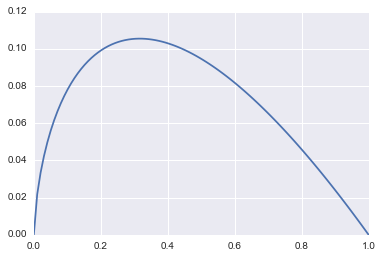

In [15]:
uni = np.linspace(0, 1, 100)
uni34 = uni ** (3/4)
plt.plot(uni, uni34 - uni);

Most of the samplers were written as generators, except for the last one, `neg_sampler_inplace`, which modifies an array in-place with random samples. As much as this in-place modification conflicts with my usual approach, it ended up being necessary for a final numba performance boost.

The generator sampler I ended up going with, `neg_sampler_jit_pad`, is padded with a couple of dummy entries. I originally drew some negative samples `negsamps` from one of these generators, and then created the array to index $W$ by prepending `negsamps` with `w` and `c`, copying these to a new array. Usually this is ok, but I found that copying `negsamps` to a new array in the inner loop caused a noticeable delay, so I wrote `neg_sampler_jit_pad` to return 2 extra empty elements at the beginning to be able to insert `w` and `c` inplace without copying to a new array.

In [16]:
def unigram(txt, pow=.75):
    "Unigram^(3/4) model"
    cts = Series(Counter(txt))
    
    # If txt is integers, fill in missing values (likely for unknown token)
    # with 0 probability to reliably use index to identify token
    int_txt = cts.index.dtype == int
    if int_txt:
        missing_tokens = set(range(cts.index.max())) - set(cts.index)
        for msg in missing_tokens:
            cts.loc[msg] = 0
        cts = cts.sort_index()
        
    N = len(txt)
    ctsdf = ((cts / cts.sum()) ** pow).reset_index(drop=0)
    ctsdf.columns = ['Word', 'Prob']
    if int_txt:
        assert (ctsdf.Word == ctsdf.index).all()
    return ctsdf

def cum_prob_uni(xs, pow=.75):
    ug = unigram(xs, pow=pow)
    return ug.Prob.cumsum().div(ug.Prob.sum()).values


def neg_sampler_pd(xs, K, pow=.75):
    "Simplest, but slowest sampler using built-in pandas sample function"
    ug = unigram(xs, pow=pow)
    for seed in count():
        yield ug.Word.sample(n=K, weights=ug.Prob, random_state=seed, replace=True)
        
        
def neg_sampler_np(xs, K, cache_len=1000, use_seed=False, pow=.75, ret_type=np.ndarray):
    "Faster neg. sampler without the pandas overhead"
    ug = unigram(xs, pow=pow)
    p = ug.Prob.values / ug.Prob.sum()
    a = ug.Word.values

    def neg_sampler_np_():
        for seed in count():
            if use_seed:
                nr.seed(seed)
            Wds = nr.choice(a, size=(cache_len, K), p=p)
            for wds in Wds:
                yield wds
                
    agen = neg_sampler_np_()            
    if ret_type == list:
        return imap(list, agen)
    assert ret_type == np.ndarray, 'Only defined for type in {np.ndarray, list}'
    return agen


def neg_sampler_jit(xs, K, pow=.75, ret_type=list):
    cum_prob = cum_prob_uni(xs, pow=pow)
    sampler = {
        list:     nbu.neg_sampler_jitl_,
        np.ndarray: nbu.neg_sampler_jita_,
    }[ret_type]
    return sampler(cum_prob, K)

def neg_sampler_jit_pad(xs, K, pow=.75, ret_type=list, pad=0):
    cum_prob = cum_prob_uni(xs, pow=pow)
    sampler = {
        list:     nbu.neg_sampler_jitl_pad,
        np.ndarray: nbu.neg_sampler_jita_pad,
    }[ret_type]
    return sampler(cum_prob, K, pad=pad)

def neg_sampler_inplace(xs, K, pow=.75, pad=0, ret_type=np.ndarray, seed=None):
    use_seed = seed is not None and False
    seed = seed or 0
    cum_prob = cum_prob_uni(xs, pow=pow)
    a = np.empty(K + pad, dtype=np.int64)
    
    @njit
    def neg_sampler_jit_pad_arr_(a):
        if use_seed:
            nr.seed(seed)
        for i in xrange(pad, K + pad):
            a[i] = nbu.bisect_left_jit(cum_prob, nr.rand())
    return a, neg_sampler_jit_pad_arr_

def neg_sampler_inplace_gen(xs, K, pow=.75, pad=0, ret_type=np.ndarray):
    a, neg_sampler_jit_pad_arr_ = neg_sampler_inplace(xs, K, pow=pow, pad=pad)
    for _ in it.repeat(None):
        neg_sampler_jit_pad_arr_(a)
        yield a[pad:].copy()
#         for i in a[pad:]:
#             yield i

### Check distributions

Just as a sanity check that the different implementations do the same thing, I randomly generate words according to how frequently they occur in the text with each of the samplers and scatter-plot them against the actual word frequency to check that they mostly lie on $y=x$. 

In [17]:
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import brown
some_text = take(brown.words(), int(1e6))

In [18]:
le = LabelEncoder()
smtok = le.fit_transform(some_text)

In [19]:
class NegSampler:
    """Container for the sampler generator functions.
    This keeps track of the number of samples $K$ and the padding."""
    def __init__(self, sampler, toks, K=None, ret_type=None, pad=None, nxt=True, **kw):
        if pad is not None:
            kw['pad'] = pad
        if ret_type is not None:
            kw['ret_type'] = ret_type
        
        self.sampler = sampler(toks, K, **kw)
        if nxt:
            a = next(self.sampler)
            if ret_type:
                assert isinstance(a, ret_type)
        self.toks = toks
        self.K = K
        self.ret_type = ret_type
        self.pad = pad or 0
        
    def __iter__(self):
        return self.sampler
    
    def __next__(self):
        return next(self.sampler)
    
    def __repr__(self):
        return ('NegSampler(pad={pad}, K={K}, type={ret_type.__name__})'
                .format(pad=self.pad, K=self.K, ret_type=self.ret_type))

In [20]:
gen_pd =       NegSampler(neg_sampler_pd, smtok, 8)
gen_npl =      NegSampler(neg_sampler_np, smtok, 8, ret_type=list)
gen_npa =      NegSampler(neg_sampler_np, smtok, 8, ret_type=np.ndarray)
gen_jitl =     NegSampler(neg_sampler_jit, smtok, 8, ret_type=list)
gen_jitl_pad = NegSampler(neg_sampler_jit_pad, smtok, 8, ret_type=list, pad=2)
gen_jita =     NegSampler(neg_sampler_jit, smtok, 8, ret_type=np.ndarray)
gen_jita_pad = NegSampler(neg_sampler_jit_pad, smtok, 8, ret_type=np.ndarray, pad=2)

In [21]:
gen_jita_padi = NegSampler(neg_sampler_inplace_gen, smtok, 8, ret_type=np.ndarray, pad=2)

In [23]:
run_n = lambda gen, n=10000: ilen(it.islice(gen, n))
%timeit run_n(gen_pd, n=1000)
%timeit run_n(gen_npl)
%timeit run_n(gen_npa)
%timeit run_n(gen_jitl)
%timeit run_n(gen_jitl_pad)
%timeit run_n(gen_jita)
%timeit run_n(gen_jita_pad)
%timeit run_n(gen_jita_padi)

1 loops, best of 3: 3.43 s per loop
10 loops, best of 3: 32.2 ms per loop
10 loops, best of 3: 20 ms per loop
100 loops, best of 3: 19.5 ms per loop
10 loops, best of 3: 20.3 ms per loop
100 loops, best of 3: 15 ms per loop
100 loops, best of 3: 15.3 ms per loop
10 loops, best of 3: 21.8 ms per loop


In [24]:
n = 100000
csp = Series(Counter(x for xs in it.islice(gen_pd, n // 100) for x in xs))
csnp = Series(Counter(x for xs in it.islice(gen_npl, n) for x in xs))
csj = Series(Counter(x for xs in it.islice(gen_jita_pad, n) for x in xs[2:]))
cs_ip = Series(Counter(x for xs in it.islice(gen_jita_padi, n) for x in xs))
# cs_ip = Series(Counter(x for _ in xrange(n) for x in inplace(a_) or a_[2:]))

ug = unigram(smtok, pow=.75)
cts = DataFrame({'Numba': csj, 'Numpy': csnp, 'Pandas': csp, 'Inplace': cs_ip}).fillna(0)
probs = cts / cts.sum()
probs['Probs'] = ug.Prob / ug.Prob.sum()

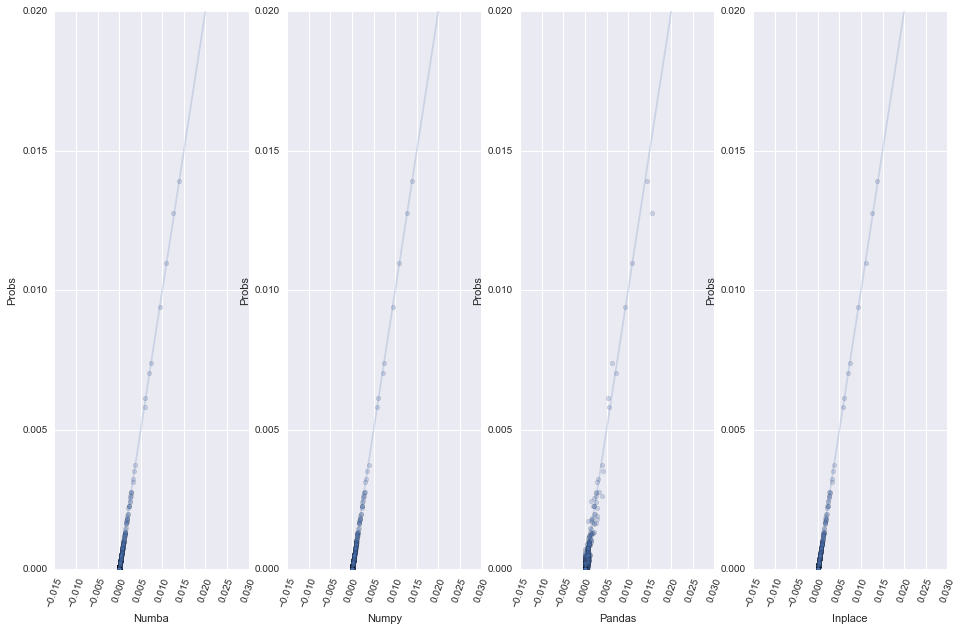

In [68]:
def plot_dist(xcol=None, subplt=None):
    plt.subplot(subplt)
    probs.plot(x=xcol, y='Probs', ax=plt.gca(), kind='scatter', alpha=.25)
    _, xi = plt.xlim(None)
    _, yi = plt.ylim(0, None)
    end = min(xi, yi)
    plt.plot([0, end], [0, end], alpha=.2)
    plt.xticks(rotation=70)
    
plt.figure(figsize=(16, 10))
plot_dist(xcol='Numba', subplt=141)
plot_dist(xcol='Numpy', subplt=142)
plot_dist(xcol='Pandas', subplt=143)
plot_dist(xcol='Inplace', subplt=144)

In [26]:
del smtok, le

As these plots show, the samplers seem to be drawing words according to the expected distribution. The pandas sampler was so slow that I had to reduce the number of draws by a couple orders of magnitude, so the plot is a lot noisier than the others, but still roughly on track. The in-place sampler appears to be slower on the microbenchmarks, but gives an improvement when restructuring the gradient update routine.

### Sliding window
It turned out another significant bottleneck of the gradient descent routine was the sliding window code that iterates over the entire corpus, yielding a word and its context words at each point. 

For the first few words in the text sequence, there are less than $C$ surrounding context words, so some checking is required. For the numba function, I used a specialized iterator at the beginning and end to avoid checking the max and min indices at every step.
Just like in the negative sampler section, I first wrote the sliding window functions in a generator style, and converted the fastest version to an inplace modification style.

In [27]:
def sliding_window(xs, C=4, start_pos=0):
    """Iterate through corpus, yielding input word
    and surrounding context words"""
    winsize = C // 2
    N = len(xs)
    for i, x in enumerate(xs, start_pos):
        ix1 = max(0, i-winsize)
        ix2 = min(N, i+winsize+1)
        yield x, xs[ix1:i] + xs[i + 1:ix2]

@njit
def sliding_window_jit(xs, C=4):
    """Iterates through corpus, yielding input word
    and surrounding context words"""
    winsize = C // 2
    N = len(xs)
    for i in xrange(winsize):
        yield nbu.bounds_check_window(i, xs, winsize, N)
    for i in xrange(winsize, N-winsize):
        context = []
        for j in xrange(i-winsize, i+winsize+1):
            if j != i:
                context.append(xs[j])
        yield xs[i], context
    for i in xrange(N-winsize, N):
        yield nbu.bounds_check_window(i, xs, winsize, N)

@njit
def sliding_window_jit_arr(xs, C=4):
    """Iterates through corpus, yielding input word
    and surrounding context words"""
    winsize = C // 2
    N = len(xs)
    for i in xrange(winsize):
        yield nbu.bounds_check_window_arr(i, xs, winsize, N)
    for i in xrange(winsize, N-winsize):
        context = np.empty(C, dtype=np.int64)
        for ci in xrange(winsize):
            context[ci] = xs[i - winsize + ci]
            context[winsize + ci] = xs[i + 1 + ci]
        yield xs[i], context
    for i in xrange(N-winsize, N):
        yield nbu.bounds_check_window_arr(i, xs, winsize, N)

In [28]:
@njit
def sliding_window_inplace(xs, i, C=4):
    winsize = C // 2
    N = len(xs)
    if i < winsize:
        return nbu.bounds_check_window_arr(i, xs, winsize, N)
    elif i < N-winsize:
        context = np.empty(C, dtype=np.int64)
        for ci in xrange(winsize):
            context[ci] = xs[i - winsize + ci]
            context[winsize + ci] = xs[i + 1 + ci]
        return xs[i], context
    elif i < N:
        return nbu.bounds_check_window_arr(i, xs, winsize, N)
    raise ValueError('Out of bounds')
    
def sliding_window_ix_(xs, C=4):
    return (sliding_window_inplace(xs, i, C=C) for i in xrange(len(xs)))

In [29]:
samp_toks = nr.randint(0, 1e6, size=100005)
samp_toksl = list(samp_toks)
list(sliding_window_jit(samp_toksl[:10], C=4))
run_window = lambda f, toks=samp_toksl: [ut.ilen(xs) for xs in f(toks, C=4)]

In [30]:
to_lst = lambda xs: [(c, list(ys)) for c, ys in xs]
assert to_lst(sliding_window_ix_(samp_toks[:10], C=4)) == to_lst(sliding_window_jit_arr(samp_toks[:10], C=4))

In [31]:
%timeit run_window(sliding_window)
%timeit run_window(sliding_window_jit)
%timeit run_window(sliding_window_jit_arr, toks=samp_toks)
%timeit run_window(sliding_window_ix_, toks=samp_toks)

10 loops, best of 3: 180 ms per loop
10 loops, best of 3: 132 ms per loop
10 loops, best of 3: 117 ms per loop
10 loops, best of 3: 179 ms per loop


### Norm
Since I'm using the concatenated input and output matrix, half of the `w, c, negsamps` submatrix entries are 0. On each iteration I check the gradient matrix's norm to clip the gradient if necessary. A specialized norm function taking this structure into account gives about an order of magnitude speedup over the numpy one. 

In [32]:
@njit
def grad_norm(Wsub):
    """Calculate norm of gradient, where first row
    is input vector, rest are output vectors. For any row,
    half of the entries are zeros, which allows a lot of
    skipping for a faster computation"""
    n = Wsub.shape[1] // 2
    sm = 0
    for i in xrange(n):
        sm += Wsub[0, i] ** 2
    for i in xrange(1, len(Wsub)):
        for j in xrange(n, 2 * n):
            sm += Wsub[i, j] ** 2
    return np.sqrt(sm)

In [33]:
grd = ns_grad_jit(Wsub)
assert np.isclose(grad_norm(grd), np.linalg.norm(grad_norm(grd)))

%timeit np.linalg.norm(grad_norm(grd))
%timeit grad_norm(grd)

The slowest run took 5.84 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.71 µs per loop
1000000 loops, best of 3: 648 ns per loop


## Gradient descent
That does it for optimizing most of the individual pieces.
For the gradient descent routine, I'm passing all the hyper-parameters through a configuration dictionary, validated by [voluptuous](https://pypi.python.org/pypi/voluptuous). This lets me specify of things like the context window size, learning rate, number of negative samples and size of the word vectors. Check the utility file `wordvec_utils.py` where it's defined for details on the meanings of the parameters.

In [34]:
all_text = list(brown.words())
use_words_ = z.valfilter(lambda x: x >= 5, Counter(all_text))
use_words = [w for w in all_text if w in use_words_]
le = LabelEncoder()
toka = le.fit_transform(use_words)
tokl = list(toka)
vc = le.classes_

In [35]:
cnf = ut.AttrDict(
    eta=.1, min_eta=.0001, accumsec=0,
    N=100, C=4, K=6, iter=0, thresh=15, epoch=0,
    pad=0,
    term=dict(iters=None,
              secs=None
    ),
    dir='cache',
)
cnf = Conf(cnf)
cnf_ = cnf
del cnf
cfp = update(cnf_, pad=2, term={})

W = wut.init_w(len(vc), cnf_.N, seed=1)
We = W.copy()

### Sgd
One final speedup I got was from putting the entire inner loop routine into a numba JIT'd function, instead of calling each JIT'd function separately. Numba seems to reduce some of python's function call overhead, as well as the numpy indexing. For some reason, merely indexing into a numpy array (to calculate the gradient and then update the original matrix) still ended up being a significant bottleneck, though numba seemed to reduce it.

Since Numba doesn't allow passing functions in as parameters, `mk_grad_update` is a higher order vanilla Python function that returns either a regular numpy function, or the same function with a numba decorator and a numba gradient function in the closure.

In [36]:
%load_ext line_profiler

In [37]:
def mk_grad_update(jit=False, grad_func=ns_grad):
    if jit:
        grad_func = ns_grad_jit
        norm_func = grad_norm
        deco = njit
    else:
        norm_func = np.linalg.norm
        deco = lambda x: x
        
    def grad_update(W, sub_ixs, eta):
        Wsub = W[sub_ixs]
        grad = grad_func(Wsub)
        gnorm = norm_func(grad)
        if gnorm > 5:  # clip gradient
            grad /= gnorm
        W[sub_ixs] = Wsub - eta * grad
        
    return deco(grad_update)

grad_update = mk_grad_update(jit=False)
grad_update_jit = mk_grad_update(jit=True)

In [69]:
@njit
def grad_update_jit_pad(W, sub_ixs, eta, w=0, c=0):
    """If focus or context word are contained in negative samples,
    drop them before performing the grad update.
    """
    sub_ixs = nbu.remove_dupes(sub_ixs, w, c)
    grad_update_jit(W, sub_ixs, eta)
    
def inner_update(W, negsamps, eta, w=0, c=0):
    """Numpy inner loop gradient update function.
    I.e., slow version of `grad_update_jit_pad`"""
    #print(negsamps, eta, w, c)
    if (w in negsamps) or (c in negsamps):
        negsamps = [x for x in negsamps if x not in {w, c}]
    sub_ixs = np.array([w, c] + negsamps) # list(negsamps)
    grad_update(W, sub_ixs, eta)
    
def check_padding(sampler, k, grad_update, dims=1):
    "Poor dependent type checker"
    _samp = next(sampler)[0] if dims == 2 else next(sampler)
    k_ = len(_samp)
    padded = k_ == 2 + k
    assert k_ == sampler.pad + sampler.K
    assert k == sampler.K
    assert k_ in (2 + k, k), ('Length of samples'
        ' should be either `k` or `k` + 2 if padded')
    assert padded == (grad_update in padded_updates), (
        'Make sure sampler size agrees with grad_update')

padded_updates = {grad_update_jit_pad}

gen_npl = NegSampler(neg_sampler_np, tokl, K=cnf_.K, ret_type=list)
numpy_opts = dict(ns_grad_=ns_grad, neg_sampler=gen_npl,
                  sliding_window=sliding_window, grad_update=inner_update)

ngsamp_pad = NegSampler(neg_sampler_jit_pad, tokl, cfp.K,
                        ret_type=np.ndarray, pad=2)
fast_opts = dict(ns_grad_=ns_grad_jit, neg_sampler=ngsamp_pad,
                 sliding_window=sliding_window_jit,
                 grad_update=grad_update_jit_pad)

And finally, here is the full gradient descent function put together.

In [39]:
def sgd(W=None, corp=None, cf={}, ns_grad_=ns_grad, neg_sampler=None,
        vc=None, sliding_window=sliding_window, grad_update=grad_update_jit_pad):
    check_padding(neg_sampler, cf.K, grad_update)
    if not os.path.exists(cf.dir):
        os.mkdir(cf.dir)
    st = time.time(); cf = Conf(cf)  #.copy()
    assert cf.N == W.shape[1] / 2, 'shape of W disagrees with conf'
    
    iter_corpus = corp[cf.iter:] if cf.iter else corp
    learning_rates = np.linspace(cf.eta, cf.min_eta, len(iter_corpus))
    assert neg_sampler is not None, "Give me a negative sampler!"
    
    iters_ = izip(count(cf.iter),
                  sliding_window(iter_corpus, C=cf.C),
                  z.partition(cf.C, neg_sampler),
                  learning_rates,
                 )
    iters = ut.timeloop(iters_, **cf.term)

    for i, (w, cont_), negsamp_lst, eta in iters:
        cont = [x for x in cont_ if x != w] if w in cont_ else cont_
        for c, negsamps in izip(cont, negsamp_lst):
            grad_update(W, negsamps, eta, w=w, c=c)

    tdur = time.time() - st
    cf2 = update(cf, iter=i+1)  # , norms=norms, gradnorms=gradnorms
    cf2['accumsec'] += tdur
    if not cf2.term and 0:
        fn = join(cf2.dir, 'n{}_e{}.csv'.format(cf.N, cf.epoch))
        DataFrame(W, index=vc).to_csv(fn)
        cf2['epoch'] += 1
        cf2 = update(cf2, iter=0)
    else:
        pass
    #     print(i, 'iters')
    return W, cf2

_ = sgd(W=We.copy(), corp=tokl, cf=update(cnf_, term={'iters': 1000}), **fast_opts)

In [40]:
def mk_sgd_inplace(cf=None, sampler=None):
    iters = cf.term.get('iters') or 0
    
    @njit
    def loop(W, toka, eta=None, min_eta=None, C=None, K=None, pad=None):
        N = iters or len(toka)
        sub_ixs = np.empty(K + pad, np.int64)
        etas = np.linspace(eta, min_eta, N)
        for i in xrange(N):
            w, conts = sliding_window_inplace(toka, i, C=C)
            eta_ = etas[i]
            for c in conts:
                sampler(sub_ixs)
                grad_update_jit_pad(W, sub_ixs, eta_, w=w, c=c)
        return W
    kwa = z.keyfilter(lambda x: x in 'eta min_eta C K pad'.split(), cf)
    looper = partial(loop, **kwa)
    return looper

a, inplace_sampler = neg_sampler_inplace(toka, cfp.K, pow=.75, pad=cfp.pad, ret_type=np.ndarray, seed=2)
sgd_inplace = mk_sgd_inplace(cfp, sampler=inplace_sampler)
# loop(w1, toka[:100], eta=cnf.eta, min_eta=cnf.min_eta, C=cnf.C, K=cnf.K, pad=2)
w1 = We.copy()
sgd_inplace(w1, toka[:100]); None

In [41]:
!say done

### Benchmarks

Now that everything is coded up, it's time to do some benchmarks. I'm curious about how well this numba code compares to both the numpy version and the uber-optimized gensim Cython code. For the comparison, I ran the algorithms on the Brown corpus [packaged with NLTK](http://www.nltk.org/nltk_data/) (loaded above as an array of integer tokens to variable `toka` in the [Gradient descent](#Gradient-descent) section). After running these, I realized that as close as I tried to follow the papers, there's still some interesting implementation differences between gensim and what I came up with, as far as the way the negative sampling gradients are applied to the word vectors. So even after running the algorithms over the same corpus, there's a pretty sizable gap in the word vector norm. To get an idea of how comparable the word vectors are, I compare the accuracy of completing analogies from the respective word vectors, using a file that came with gensim.

(To reproduce the gensim vectors, you'll need to run `export PYTHONHASHSEED=42` in the terminal before even starting the ipython notebook, though I'm not even sure how well python's randomness can be reproduced on different systems and versions.)

#### Numba

In [72]:
time.clock()

772.110345

In [74]:
def timer(f):
    @wraps(f)
    def tf(*a, **k):
        t1 = time.clock()
        res = f(*a, **k)
        t2 = time.clock()
        return res, t2 - t1
    return tf

In [80]:
print('PYTHONHASHSEED={}'.format(os.environ.get('PYTHONHASHSEED')))
nseed(41)
w1, t_numba = timer(sgd_inplace)(We.copy(), toka)
print('Numba score: {}'.format(wut.score_wv(w1, vc)))
print('Numba wordvec norm: {:.2f}'.format(norm(w1)))
print('=> {:.2f}s'.format(t_numba))

PYTHONHASHSEED=42
Numba score: 182
Numba wordvec norm: 351.30
=> 54.48s


#### Numpy

In [ ]:
nr.seed(41)  # 182
w2 = We.copy()
(w2, _), t_np = timer(sgd)(W=w2, corp=tokl, cf=update(cnf_, term={}), **numpy_opts)
print('Numpy score: {}'.format(wut.score_wv(w2, vc)))
print('Numpy wordvec norm: {:.2f}'.format(norm(w2)))
print('=> {:.2f}s'.format(t_np))

#### Gensim Cython

In [47]:
import gensim
from gensim.models.word2vec import Word2Vec
gparams = ut.to_gensim_params(cnf_)

def gensim_eval(mod):
    ans = mod.accuracy('src/questions-words.txt')  # , restrict_vocab=10000
    sect = [d for d in ans if d['section'] == 'total']
    return sum([1 for d in sect for _ in d['correct']])

import gensim
from numpy.linalg import norm
from nltk.corpus import brown
import numpy.random as nr

gparams = {'alpha': 0.1,
 'min_alpha': 0.0001,
 'negative': 6,
 'sample': 0,
 'sg': 1,
 'size': 100,
 'window': 2.0}

In [48]:
ut.reset_gensim(slow=False, gensim=gensim)
assert gensim.models.word2vec.FAST_VERSION == 1

1 epoch

In [81]:
# %time 
gen_fast, t_gen = timer(Word2Vec)(brown.sents(), seed=42, iter=1, workers=1, **gparams)
print('Gensim score: {}'.format(gensim_eval(gen_fast)))
print('Gensim wordvec norm: {:.2f}'.format(norm(gen_fast.syn0)))
print('=> {:.2f}s'.format(t_gen))

Gensim score: 109
Gensim wordvec norm: 209.85
=> 10.64s


2 epochs

In [82]:
gen_fast2, t_gen2 = timer(Word2Vec)(brown.sents(), seed=42, iter=2, workers=1, **gparams)
print('Gensim score: {}'.format(gensim_eval(gen_fast2)))
print('Gensim wordvec norm: {:.2f}'.format(norm(gen_fast2.syn0)))
print('=> {:.2f}s'.format(t_gen2))

Gensim score: 181
Gensim wordvec norm: 243.99
=> 17.81s


In [99]:
t_numba / t_gen2

3.059388558211868

In [ ]:
ts = Series(dict(Gensim=t_gen, Gensim2=t_gen2, Numba=t_numba, Numpy=t_np))
DataFrame(ts[:, None] / ts[:, None].T, index=ts.index, columns=ts.index)

           Gensim   Gensim2     Numba
Gensim   1.000000  0.597221  0.195209
Gensim2  1.674422  1.000000  0.326863
Numba    5.122707  3.059389  1.000000

## Conclusion
It looks like with all my numba optimizations, I'm able to get about 7x speedup over numpy, for about the same word vectors (the norms are close and the analogy accuracy score is the same). But despite the numba optimizations, my implementation is still about 5x slower than gensim's Cython version. With the possible implementation differences mentioned above, though, it looks like gensim produces word vectors more similar to mine after 2 epochs, at least in terms of word analogy accuracy. Running 2 gensim epochs gets me down to 'only' 3 times slower, but this is even with limiting gensim to a single worker. I should probably be happy with these numbers, since the gensim contributors really know what they're doing, but going through this has given me a greater appreciation of the dark cython magic they're using behind the scenes. 

Along with word2vec, this was also my first dive into programming with numba. It was a bit tricky navigating around some restrictions like higher-order functions, and I missed being able to avoid lower level for-loop style programming. Interpreting numba error messages was also a pain point, but I assume that's something I'll get better at the more I use it and the more it's developed. But overall I'm really happy with the speed increases it gives, as well as being able to stick to 'pretty much Python.' Numeric computing projects out of the python community never cease to impress me.

#### Gensim slow

In [ ]:
ut.reset_gensim(slow=True, gensim=gensim)
assert gensim.models.word2vec.FAST_VERSION == -1

In [ ]:
%time gen_slow = Word2Vec(brown.sents(), seed=41, **gparams)
gensim_eval(gen_slow)

In [ ]:
reload(wut)

In [ ]:
!say derp

In [ ]:
norm(w1)

In [ ]:
gen_fast.syn0.shape

In [ ]:
norm(gen_fast.syn0)

In [ ]:
sns.set_palette('Paired')

In [ ]:
sdf.groupby('Name')[0].agg(['mean', 'median'])
"""
            mean  median
Name                    
Gs1   127.500000   122.0
Gs2   194.250000   191.5
N1    177.333333   179.0
N2    212.800000   213.0"""

In [ ]:
sns.violinplot(x='Name', y=0, data=sdf)

# TODO: ~
[#Begin](#Begin)

## Corpus

In [ ]:
from sklearn.preprocessing import LabelEncoder

def to_ints(wds):
    le = LabelEncoder().fit(wds)
    ints = le.transform(wds)
    return list(ints), le

def to_list_gen(f):
    @wraps(f)
    def f2(*a, **kw):
        gen = f(*a, **kw)
        return (list(x) for x in gen)
    return f2

def tokenize(wds):
    alpha_re = re.compile(r'[A-Za-z]')
    return [w for w in wds if alpha_re.search(w)]

def prune_words(wds, keep_n_words=30000, min_counts=None):
    if (keep_n_words is None) and (min_counts is None):
        return wds
    cts = Counter(wds)
    if min_counts is not None:
        return [w for w in wds if cts[w] >= min_counts]
    elif keep_n_words is not None:
        keeps = set(sorted(cts, key=cts.get, reverse=True)[:keep_n_words])
        
    return [w for w in wds if w in keeps]

# c2 = prune_words(brown.words(), keep_n_words=10)

In [ ]:
toks, le = to_ints(nopunct)

In [ ]:
def from_gensim_params(params, cnf, **upkw):
    gsim2param_names = dict(negative='K', alpha='eta', size='N')
    newparams = {pn: params[gn] for gn, pn in gsim2param_names.items()}
    newparams['C'] = params['window'] * 2
    cnf2 = update(cnf, **newparams, **upkw)
    return cnf2

cnff = Conf(from_gensim_params(gparams, cnf, dir='cache/v13'))
# cnff

In [ ]:
params = gparams
params

In [ ]:
class word2vec(object):
    def __init__(self, words, cnf, neg_sampler=to_list_gen(neg_sampler_np),
                 keep_n_words=None, min_counts=None, **sgd_kwds):
        text = prune_words(tokenize(words), keep_n_words=keep_n_words, min_counts=min_counts)
        
        self.text = text
        self.toks, self.le = to_ints(self.text)
        self.cnf = update(cnf, term={})
        self.W = wut.init_w(len(self.le.classes_), cnf.N)
        self.sgd_kwds = sgd_kwds
        self.neg_sampler = neg_sampler(self.toks, cnf.K)
        
    def run(self, term=None, **sgd_kwds):
        cnf = self.cnf
        if term:
            cnf = update(cnf, term=term)
        res = sgd(W=self.W.copy(), corp=self.toks, neg_sampler=self.neg_sampler,
                  cf=cnf, vc=self.le.classes_, **z.merge(self.sgd_kwds, sgd_kwds))
        self.W, self.cnf = res
        
    @property
    def df(self):
        return DataFrame(self.W.copy(), index=self.le.classes_)

modf = word2vec(brown.words(), cnff, neg_sampler=neg_sampler_j, keep_n_words=None, min_counts=5)

In [ ]:
%time modf.run()

In [ ]:
with open('cache/txt.txt','w') as f:
    f.write('\n'.join(modf.text))

In [ ]:
fast_opts = dict(ns_grad=ns_grad_jit, sliding_window=sliding_window_jit)

In [ ]:
%%time
for i in range(4):   
    modf.run(term={}, **fast_opts)  # 'iters': 10000
!say done

In [ ]:
modf.run(term={}, **fast_opts)

In [ ]:
gmod = 

In [ ]:
gparams

In [ ]:
Word2Vec

In [ ]:
modf.cnf

## Evaluate
[#Benchmarks](#Benchmarks)

[#Begin](#Speed)

# Eval

In [ ]:
Tokyo:Japan::Warsaw:*U.S.S.R.* (Poland)
Philadelphia:Pennsylvania::Seattle:*AFL-CIO* (Washington)
                
- line profiler
- create array
- index with list

## Update equation
$$
    \frac{\partial E}
         {\partial \boldsymbol v_{w_j}^{\prime T} \boldsymbol h}
         = \sigma(\boldsymbol v_{w_j}^{\prime T} \boldsymbol h) -t_j
$$